# Extending Regenerative Gene Sequences into Biological Implications

By: Jaeyoon Jung, Jeremy Milford, Shree Patel, Cynthia Perez

This notebook develops a model from gene sequences of the axolotl and zebrafish, model regenerative species. This notebook uses feature engineered data to run gridsearch, PCA, and maps the gene data to amino acid sequences to explore biological implications. 

### Necessary Imports

In [1]:
# necessary imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import shap
from scipy.stats import ttest_ind


2024-12-01 17:24:34.619738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 17:24:34.623207: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 17:24:34.807957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 17:24:35.090799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733091875.257056  477253 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733091875.31

In [3]:
features_df = pd.read_csv("gene_features_3mer.csv")
features_df.head()

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_GGG,kmer_3_GGC,kmer_3_GCG,kmer_3_CGG,kmer_3_GCT,kmer_3_CTG,...,kmer_3_GTA,kmer_3_TAG,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA,organism,chromosome,regen
0,HOXA13,2800,0.522857,0.912568,0.024303,0.022873,0.021801,0.018585,0.016083,0.019657,...,0.012509,0.006791,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,2q,1
1,TWIST3,2729,0.485892,1.058069,0.012101,0.013568,0.009534,0.009534,0.014668,0.023836,...,0.008801,0.007701,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,3q,1
2,HOXD10,4207,0.467792,1.137703,0.013793,0.014744,0.011415,0.009512,0.013793,0.017122,...,0.014982,0.009275,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,9,1
3,HOXD11,7743,0.439623,1.274677,0.016148,0.012660,0.011110,0.012014,0.013435,0.017052,...,0.013177,0.008655,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,9,1
4,TGFBR1,360240,0.465784,1.146918,0.017819,0.013591,0.006054,0.007251,0.013766,0.019581,...,0.012125,0.011559,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,5q,1


### Test, Train Split

In [4]:
# Drop gene_name and separate features and target 
X = features_df.drop(columns=['gene_name'])
y = (features_df['regen']).astype(int)  

# Choose only numeric features for modeling
X_col = X.columns
X_numeric_features = ["sequence_length", "gc_content", "at_gc_ratio", 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       'kmer_3_ATA', 'kmer_3_GTA', 'kmer_3_TAG', 'kmer_3_CAN', 'kmer_3_ANN',
       'kmer_3_NNN', 'kmer_3_NNT', 'kmer_3_NTA']

X_num = X[X_numeric_features]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)


This train, test split has considered only the numerical features of the data (i.e. no information on organism or chromosome location of the gene)

### Optimized CNN on Feature DataFrame

In [5]:
model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train, Y_train,
    epochs=50,                 # Maximum number of epochs
    batch_size=16,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping])  # Add the EarlyStopping callback here

/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-12-01 17:26:07.945297: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.4583 - loss: 0.6945 - val_accuracy: 0.4118 - val_loss: 0.6883
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5917 - loss: 0.6725 - val_accuracy: 0.5294 - val_loss: 0.6922
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5583 - loss: 0.6713 - val_accuracy: 0.5294 - val_loss: 0.6903
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6625 - loss: 0.6330 - val_accuracy: 0.5294 - val_loss: 0.7020


The parameters for this CNN are the optimized data from the gridsearch on all numeric features. 

### Extending our Results into Biology

We will use the full training dataset and the model that performs the best on that data to expand our results into biology. This is to ensure that our kmer mapping process accurately represents all mers, not just the ones present in the PCA, even though we acknowledge that our results were about 5-10% better with PCA. 

PermutationExplainer explainer: 18it [01:27,  5.13s/it]                        


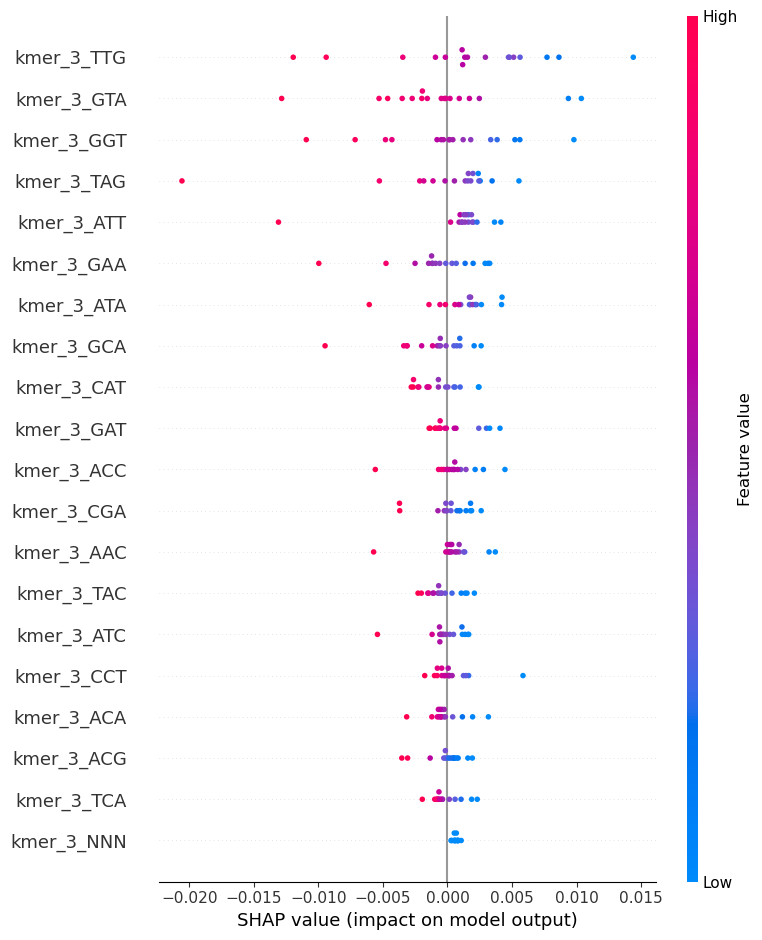

In [6]:
# Create SHAP explainer for your model
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Display summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_num.columns)

In [7]:
# Compute mean absolute SHAP values for feature importance
feature_importance = np.mean(np.abs(shap_values.values), axis=0)

# Create a DataFrame for sorting and printing
feature_names = X_num.columns  # Ensure X has feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': feature_importance
})

# Sort by SHAP importance
importance_df = importance_df.sort_values(by='SHAP Importance', ascending=False)

# Print the top 10 most influential features
print("\nTop Influential Features:")
print(importance_df.head(10))


Top Influential Features:
       Feature  SHAP Importance
63  kmer_3_TTG         0.005005
65  kmer_3_GTA         0.003552
61  kmer_3_GGT         0.003551
66  kmer_3_TAG         0.003317
62  kmer_3_ATT         0.002389
59  kmer_3_GAA         0.002215
64  kmer_3_ATA         0.002062
58  kmer_3_GCA         0.001926
55  kmer_3_CAT         0.001508
52  kmer_3_GAT         0.001293


We see that there are a hanfdul of 3mer sequences that are highest ranked in importance. We know 3 nucleotides code for a codon, which are used in amino acid generation. Are the 3-mers that we see indiciative of a particular amino acid? 

In [8]:
# Assuming the initial DataFrame is called `importance_df` and looks similar to the provided example:

# RNA Codon Table
RNA_CODON_TABLE = {
    'UUU': 'F', 'UUC': 'F', 'UUA': 'L', 'UUG': 'L',
    'UCU': 'S', 'UCC': 'S', 'UCA': 'S', 'UCG': 'S',
    'UAU': 'Y', 'UAC': 'Y', 'UAA': '*', 'UAG': '*',
    'UGU': 'C', 'UGC': 'C', 'UGA': '*', 'UGG': 'W',
    'CUU': 'L', 'CUC': 'L', 'CUA': 'L', 'CUG': 'L',
    'CCU': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAU': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGU': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'AUU': 'I', 'AUC': 'I', 'AUA': 'I', 'AUG': 'M',
    'ACU': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAU': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGU': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GUU': 'V', 'GUC': 'V', 'GUA': 'V', 'GUG': 'V',
    'GCU': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAU': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGU': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

# Step 1: Extract DNA sequences from the `Feature` column (removing prefix)
importance_df['DNA'] = importance_df['Feature'].str.replace('kmer_3_', '')

# Step 2: Convert DNA to RNA (replace T with U)
importance_df['RNA'] = importance_df['DNA'].str.replace('T', 'U')

# Step 3: Translate RNA to amino acids using the RNA codon table
importance_df['Amino Acid'] = importance_df['RNA'].map(RNA_CODON_TABLE)

dna_rna_amino_acid_df = importance_df

dna_rna_amino_acid_df.head(5)

,Feature,SHAP Importance,DNA,RNA,Amino Acid
63,kmer_3_TTG,0.005005,TTG,UUG,L
65,kmer_3_GTA,0.003552,GTA,GUA,V
61,kmer_3_GGT,0.003551,GGT,GGU,G
66,kmer_3_TAG,0.003317,TAG,UAG,*
62,kmer_3_ATT,0.002389,ATT,AUU,I


In [9]:
# Count occurrences of each amino acid
amino_acid_counts = dna_rna_amino_acid_df['Amino Acid'].value_counts()

# Display amino acid frequencies
print("Amino Acid Frequencies:")
print(amino_acid_counts)

Amino Acid Frequencies:
Amino Acid
L    6
S    6
R    6
P    4
A    4
T    4
V    4
G    4
*    3
I    3
F    2
K    2
Q    2
Y    2
N    2
D    2
H    2
E    2
C    2
M    1
W    1
Name: count, dtype: int64


In [10]:
# Aggregate SHAP importance by amino acid
amino_acid_shap = dna_rna_amino_acid_df.groupby('Amino Acid')['SHAP Importance'].sum()

# Combine counts and SHAP importance
amino_acid_analysis = pd.DataFrame({
    'Count': amino_acid_counts,
    'Total SHAP Importance': amino_acid_shap
}).sort_values(by='Total SHAP Importance', ascending=False)

amino_acid_analysis

,Count,Total SHAP Importance
Amino Acid,,
I,3,0.005493
L,6,0.005368
*,3,0.003975
V,4,0.003895
G,4,0.003610
T,4,0.003424
E,2,0.002275
A,4,0.001953
D,2,0.001843


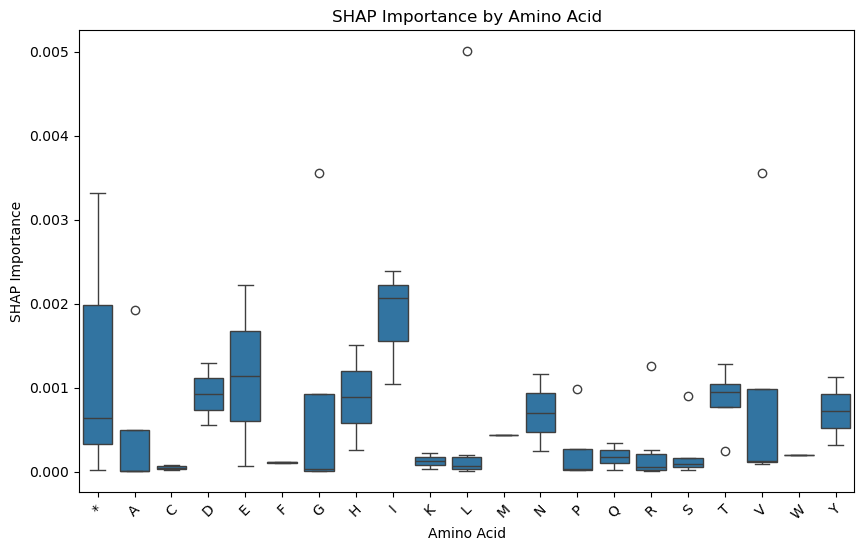

In [11]:
# Boxplot of SHAP Importance grouped by Amino Acid
plt.figure(figsize=(10, 6))
sns.boxplot(data=dna_rna_amino_acid_df, x='Amino Acid', y='SHAP Importance', order=amino_acid_shap.index)
plt.title('SHAP Importance by Amino Acid')
plt.xlabel('Amino Acid')
plt.ylabel('SHAP Importance')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Known regeneration-related amino acids
regeneration_amino_acids = ['L', 'S', 'P', 'R', 'G']

# Filter for regeneration-related amino acids
regeneration_related = amino_acid_analysis.loc[amino_acid_analysis.index.isin(regeneration_amino_acids)]

regeneration_related

,Count,Total SHAP Importance
Amino Acid,,
L,6,0.005368
G,4,0.003610
R,6,0.001655
S,6,0.001320
P,4,0.001044


In [13]:
# Separate regeneration-related and other amino acids
regen_shap = amino_acid_analysis.loc[regeneration_amino_acids, 'Total SHAP Importance']
other_shap = amino_acid_analysis.loc[~amino_acid_analysis.index.isin(regeneration_amino_acids), 'Total SHAP Importance']

# Perform t-test
t_stat, p_value = ttest_ind(regen_shap, other_shap, equal_var=False)

print(f"T-test for Regeneration vs Other Amino Acids: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

T-test for Regeneration vs Other Amino Acids: t-statistic = 0.853, p-value = 0.426


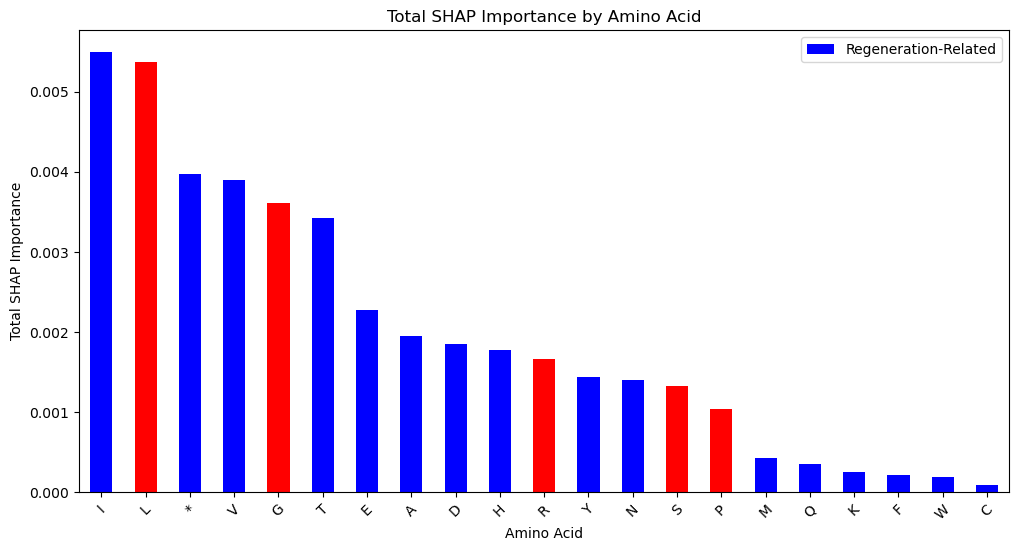

In [14]:
# Highlight regeneration-related amino acids
colors = ['red' if aa in regeneration_amino_acids else 'blue' for aa in amino_acid_analysis.index]

# Bar plot of Total SHAP Importance
plt.figure(figsize=(12, 6))
amino_acid_analysis['Total SHAP Importance'].plot(kind='bar', color=colors)
plt.title('Total SHAP Importance by Amino Acid')
plt.xlabel('Amino Acid')
plt.ylabel('Total SHAP Importance')
plt.xticks(rotation=45)
plt.legend(['Regeneration-Related', 'Other'])
plt.show()
